In [ ]:
# import libraries
try:
  # %tensorflow_version only exists in Colab.
  !pip install tf-nightly
except Exception:
  pass
import tensorflow as tf
import pandas as pd
from tensorflow import keras
!pip install tensorflow-datasets
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
2.12.0-dev20221204


In [ ]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
!wget https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv

train_file_path = "train-data.tsv"
test_file_path = "valid-data.tsv"

--2022-12-04 17:52:12--  https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.3.33, 104.26.2.33, 172.67.70.149, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.3.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 358233 (350K) [text/tab-separated-values]
Saving to: ‘train-data.tsv.5’

train-data.tsv.5    100%[===================>] 349.84K  --.-KB/s    in 0.03s   

2022-12-04 17:52:12 (10.6 MB/s) - ‘train-data.tsv.5’ saved [358233/358233]

--2022-12-04 17:52:12--  https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.3.33, 104.26.2.33, 172.67.70.149, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.3.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 118774 (116K) [text/tab-separated-values]
Saving to: ‘valid-data.tsv.5’

valid-data.tsv.5    100%[========

## Preprocessing

In [ ]:
data_train=pd.read_csv(train_file_path,sep='\t', names=['label', 'text'])
data_test=pd.read_csv(test_file_path,sep='\t', names=['label', 'text'])

In [ ]:
train_data_list = data_train.text.to_list()
test_data_list = data_test.text.to_list()

In [ ]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()

tokenizer.fit_on_texts(train_data_list)

In [ ]:
train_sequences = tokenizer.texts_to_sequences(train_data_list)
test_sequences = tokenizer.texts_to_sequences(test_data_list)

In [ ]:
MAXLEN = max(len(elem) for elem in train_sequences)
VOCAB_SIZE = max(tokenizer.index_word.keys())+1

# Test-train split


In [ ]:
train_data = keras.utils.pad_sequences(train_sequences, MAXLEN)
test_data = keras.utils.pad_sequences(test_sequences, MAXLEN)

train_labels = data_train.label.map({'ham':0, 'spam':1})
test_labels = data_test.label.map({'ham':0, 'spam':1})

## Creating the Model

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE, 32),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(1, activation="tanh")
])

model.compile(loss="binary_crossentropy",optimizer="adam",metrics=['acc'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          246176    
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 254,529
Trainable params: 254,529
Non-trainable params: 0
_________________________________________________________________


# Training

In [ ]:
history = model.fit(train_data, train_labels, epochs=12, validation_split=0.2)

Epoch 1/12
105/105 [==============================] - 19s 156ms/step - loss: 0.2283 - acc: 0.9207 - val_loss: 0.0984 - val_acc: 0.9809
Epoch 2/12
105/105 [==============================] - 11s 102ms/step - loss: 0.0473 - acc: 0.9895 - val_loss: 0.0836 - val_acc: 0.9833
Epoch 3/12
105/105 [==============================] - 9s 87ms/step - loss: 0.0336 - acc: 0.9961 - val_loss: 0.0877 - val_acc: 0.9892
Epoch 4/12
105/105 [==============================] - 9s 86ms/step - loss: 0.0266 - acc: 0.9982 - val_loss: 0.0792 - val_acc: 0.9844
Epoch 5/12
105/105 [==============================] - 9s 86ms/step - loss: 0.0351 - acc: 0.9934 - val_loss: 0.0901 - val_acc: 0.9868
Epoch 6/12
105/105 [==============================] - 9s 86ms/step - loss: 0.0257 - acc: 0.9973 - val_loss: 0.0907 - val_acc: 0.9868
Epoch 7/12
105/105 [==============================] - 9s 87ms/step - loss: 0.0242 - acc: 0.9982 - val_loss: 0.0908 - val_acc: 0.9880
Epoch 8/12
105/105 [==============================] - 9s 86ms/ste

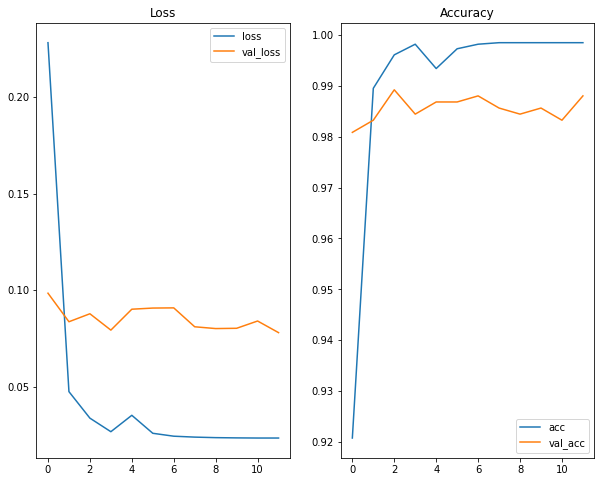

In [ ]:
df_history = pd.DataFrame(history.history)



f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))
ax1.plot(df_history[['loss','val_loss']]);
ax1.legend(['loss','val_loss'])
ax1.set_title("Loss")
ax2.plot(df_history[['acc','val_acc']]);
ax2.set_title("Accuracy");
ax2.legend(['acc','val_acc']);

# Making Predictions

In [ ]:
result = model.evaluate(test_data, test_labels)

44/44 [==============================] - 1s 18ms/step - loss: 0.1049 - acc: 0.9878


# Creating a Function

In [ ]:
# function to predict messages based on model
# (should return list containing prediction and label, ex. [0.008318834938108921, 'ham'])
def predict_message(text_to_predict):
  seq = tokenizer.texts_to_sequences([text_to_predict])
  seq_new = keras.utils.pad_sequences(seq, MAXLEN)
  pred = model.predict(seq_new)
  return [pred[0][0], 'spam' if pred[0][0]>0 else 'ham']

pred_text = "how are you doing today?"

prediction = predict_message(pred_text)
print(prediction)

1/1 [==============================] - 0s 464ms/step
[-0.5810301, 'ham']


In [ ]:
# Run this cell to test your function and model. Do not modify contents.
def test_predictions():
  test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460324",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]

  test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
  passed = True

  for msg, ans in zip(test_messages, test_answers):
    prediction = predict_message(msg)
    if prediction[1] != ans:
      passed = False

  if passed:
    print("You passed the challenge. Great job!")
  else:
    print("You haven't passed yet. Keep trying.")

test_predictions()


1/1 [==============================] - 0s 29ms/step
You passed the challenge. Great job!
